In [378]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import warnings
from matplotlib.patches import Ellipse
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, Matern

from tests import *
from gridspace import gen_gridded_space_DET, parse_map_for_GP, plot_truth_features, plot_sampled_features
from gp import GaussianProcess
from sampler import AdaptiveSampling

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Global constants
feature_scale = 2
feature_colors = [(0,1,0), (0,0,1)]
feature_dict = {
    1: (feature_colors[0], (Ellipse((-1.5, -1), 2.5, 6, 20),)), 
    2: (feature_colors[1], (Ellipse((1, 2), 8, 2, 170), Ellipse((2, -1), 6, 2, 60),))
}
feature_name_colors = (('Red', 'No Features'), ('Green', 'Feature 1'), ('Blue', 'Feature 2'))

plot_dict = {
    'feature_name_colors': feature_name_colors
}

feature_stats = [(0, 1), (6, 4), (5, 9)]

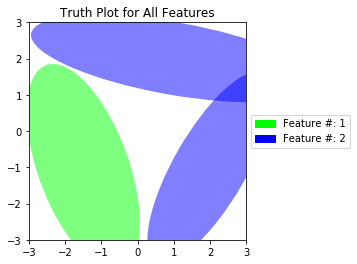

In [5]:
# plot truth features
plot_truth_features(feature_dict, oneFeature=False)

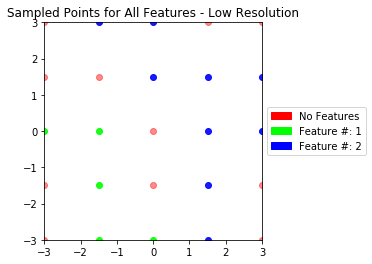

In [40]:
def test_low_resolution():
    # Test gridded representation of the features (low res, initial sample)
    N = 5
    X, Y, Z = gen_gridded_space_DET(feature_dict, N=N)

    plot_sampled_features(Z, feature_dict, N=N, titleStr='Sampled Points for All Features - Low Resolution')
    
test_low_resolution()

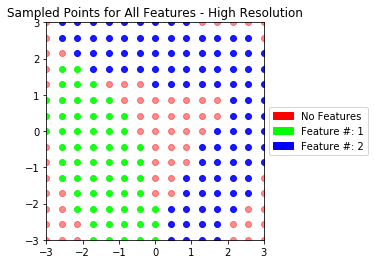

In [49]:
def test_high_resolution():
    # Test gridded representation of the features (low res, initial sample)
    N = 15
    X, Y, Z = gen_gridded_space_DET(feature_dict, N=N)

    plot_sampled_features(Z, feature_dict, N=N, plotNoFeatures=True,
                          titleStr='Sampled Points for All Features - High Resolution')
    
test_high_resolution()

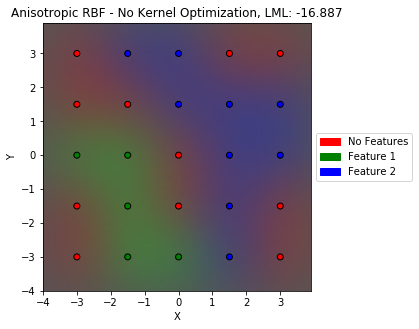

In [58]:
def test_gp(kernel, optimize, plot_dict, title, entropy=False):
    N = 5
    X, Y, Z = gen_gridded_space_DET(feature_dict, N=N)
    X_train, y_train = parse_map_for_GP(X, Y, Z)
    
    model = GaussianProcess(kernel, optimize, plot_dict)
    model.fit(X_train, y_train)
    if entropy:
        model.plot_entropy(title=title)
    else:
        model.plot_belief(title=title)

kernel = 1.0 * RBF([1.0, 1.0])
test_gp(kernel, optimize=False, plot_dict=plot_dict, title="Anisotropic RBF - No Kernel Optimization")

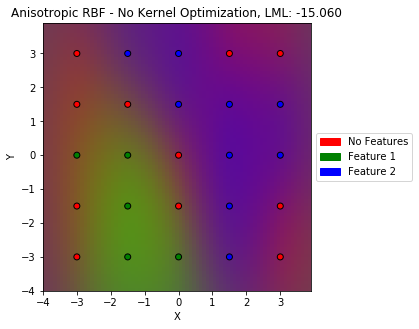

In [57]:
# test kernel optimization
kernel = 1.0 * RBF([1.0, 1.0])
test_gp(kernel, optimize=True, plot_dict=plot_dict, title="Anisotropic RBF - With Kernel Optimization")

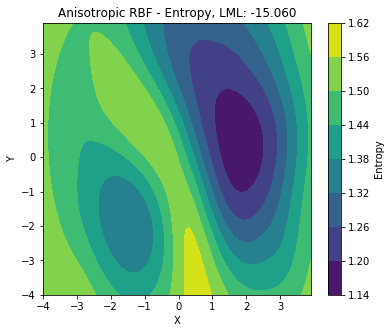

In [59]:
# test entropy plot
kernel = 1.0 * RBF([1.0, 1.0])
test_gp(kernel, optimize=True, plot_dict=plot_dict, title="Anisotropic RBF - Entropy", entropy=True)

In [150]:
class BaseSampler:
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        self.world_map = world_map
        self.science_map = science_map
        self.model = belief_model
        self.pose = init_pose
        self.feature_stats = feature_stats

        # sampling hyper-parameters
        self.beta = beta
        self.horizon = horizon
        self.distance_budget = budget['distance']
        self.sampling_budget = budget['sampling']

        self.total_reward = 0
        self.points_traveled = deque([self.pose])
        
    def _get_points_from_horizon(self, points):
        look_horizon = min([self.distance_budget, self.horizon])
        points_around = points[np.all(points != self.pose, axis=1)]
        tree = KDTree(points_around)
        ind = tree.query_radius(self.pose.reshape([1, -1]), r=look_horizon)[0]
        return points_around[ind]

    def _get_location_stats(self, point):
        point = point.reshape(1, -1)
        likelihoods = self.model.predict_proba(point)[0]
        mean = 0
        var = 0

        for i, f in enumerate(self.feature_stats):
            mean += f[0] * likelihoods[i]
            var += f[1] * likelihoods[i]

        return mean, var

    def _query_feature(self, point):
        feature = self.science_map[np.all(self.world_map == point, axis=1)]
        return feature


In [ ]:
class Sampler_1(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_1, self).__init__()
        
    def sample_only_exploit(self, points):
        raise NotImplementedError

In [ ]:
class Sampler_2(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_2, self).__init__()
        
    def sample_only_explore(self, points):
        raise NotImplementedError

In [ ]:
class Sampler_3(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_1, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def sample_explore_exploit(self, points):
        raise NotImplementedError

In [ ]:
class Sampler_4(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_4, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def update_belief(self, points):
        raise NotImplementedError

In [ ]:
class Sampler_5(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_5, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def movement_cost(self, points):
        raise NotImplementedError

In [ ]:
class Sampler_6(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_6, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def pick_next_point(self):
        raise NotImplementedError
        
    def sample_explore_exploit(self, points):
        "Paste the `sample_explore_exploit(points)` method that you have implemented in Sampler_3."
        raise NotImplementedError

In [ ]:
class AdaptiveSampler(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(AdaptiveSampler, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
    
    def start_explore(self):
        "YOUR CODE HERE"
        raise NotImplementedError
    
    def sample_explore_exploit(self, points):
        "Paste the `sample_explore_exploit` method that you have implemented in Sampler_3."
        raise NotImplementedError
        
    def pick_next_point(self):
        "Paste the `pick_next_point` method that you have implemented in Sampler_6."
        raise NotImplementedError
        
    def update_belief(self):
        "Paste the `update_belief` method that you have implemented in Sampler_4."
        raise NotImplementedError
        
    def movement_cost(self, points):
        "Paste the `movement_cost` method that you have implemented in Sampler_5."
        raise NotImplementedError

In [84]:
# test explorer
def test_explorer(budget, horizon, beta):
    X, Y, Z = gen_gridded_space_DET(feature_dict, N=3)
    X_init, y_init = parse_map_for_GP(X, Y, Z)
    X, Y, Z = gen_gridded_space_DET(feature_dict, N=50)
    world_map, science_map = parse_map_for_GP(X, Y, Z)
    
    kernel = 1.0 * RBF([1.0, 1.0])
    optimize = True
    model = GaussianProcess(kernel, optimize, plot_dict)
    model.fit(X_init, y_init)
    
    init_pose = np.array([0, 0])
    explorer = AdaptiveSampling(world_map, science_map, model, init_pose, feature_stats, budget, horizon, beta)
    explorer.start_explore()
    return explorer

In [89]:
budget = {'distance': 100, 'sampling': 30}
horizon = 2
beta = 0.6
since = time.time()
explorer = test_explorer(budget, horizon, beta)
print(time.time() - since)

2.9498307704925537


(<matplotlib.figure.Figure at 0x115754940>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1156430b8>)

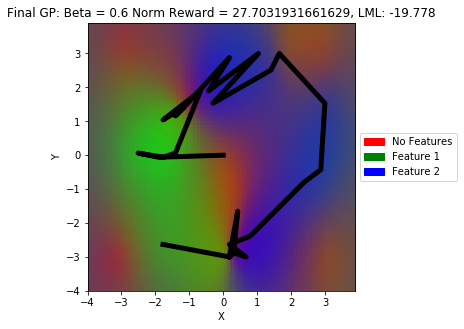

In [90]:
title = "Final GP: Beta = " + str(beta) + " Norm Reward = " + str(explorer.total_reward)
explorer.model.plot_belief(title, plotData=False, linePlot=np.array(explorer.points_traveled))

In [53]:
world_map

array([[-3.        , -3.        ],
       [-2.87755102, -3.        ],
       [-2.75510204, -3.        ],
       ...,
       [ 2.75510204,  3.        ],
       [ 2.87755102,  3.        ],
       [ 3.        ,  3.        ]])